# Figures for Italy presentation

## Collapse study

### Setup

In [2]:
import sys
# caution: path[0] is reserved for script path (or '' in REPL)
sys.path.insert(1, '../')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from doe import GP

plt.rcParams["text.usetex"] = True
plt.rcParams["font.family"] = "serif"
plt.rcParams["mathtext.fontset"] = "dejavuserif"
title_font=20
axis_font = 18
subt_font = 18
label_size = 16
mpl.rcParams['xtick.labelsize'] = label_size 
mpl.rcParams['ytick.labelsize'] = label_size 

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 
warnings.filterwarnings("ignore", category=FutureWarning) 
pd.options.mode.chained_assignment = None  

### Collapse definitions

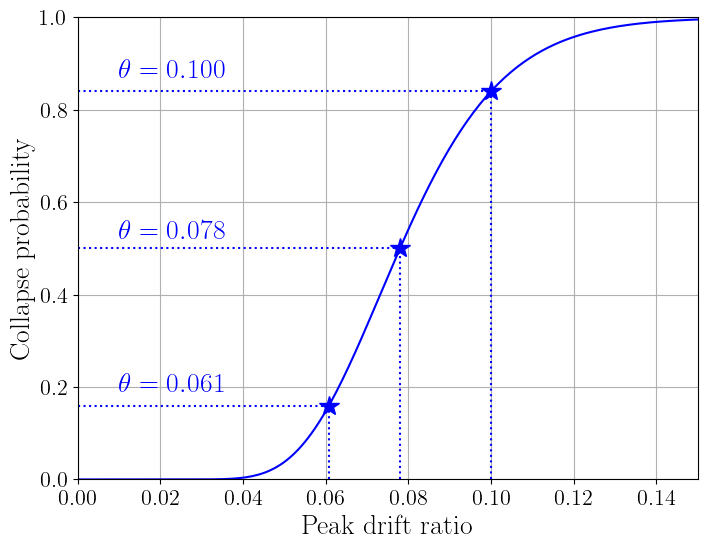

In [2]:

plt.rcParams["text.usetex"] = True
plt.rcParams["font.family"] = "serif"
plt.rcParams["mathtext.fontset"] = "dejavuserif"

# collapse as a probability
from scipy.stats import lognorm
from math import log, exp

collapse_drift_def_mu_std = 0.1


from scipy.stats import norm
inv_norm = norm.ppf(0.84)
beta_drift = 0.25
mean_log_drift = exp(log(collapse_drift_def_mu_std) - beta_drift*inv_norm) # 0.9945 is inverse normCDF of 0.84
# mean_log_drift = 0.05
ln_dist = lognorm(s=beta_drift, scale=mean_log_drift)

label_size = 16
clabel_size = 12
x = np.linspace(0, 0.15, 200)

mu = log(mean_log_drift)

ln_dist = lognorm(s=beta_drift, scale=mean_log_drift)
p = ln_dist.cdf(np.array(x))


fig, ax = plt.subplots(1, 1, figsize=(8,6))

ax.plot(x, p, label='Collapse (peak)', color='blue')

mu_irr = log(0.01)
ln_dist_irr = lognorm(s=0.3, scale=exp(mu_irr))
p_irr = ln_dist_irr.cdf(np.array(x))

# ax.plot(x, p_irr, color='red', label='Irreparable (residual)')

axis_font = 20
subt_font = 18
xright = 0.0
xleft = 0.15
ax.set_ylim([0,1])
ax.set_xlim([0, xleft])
ax.set_ylabel('Collapse probability', fontsize=axis_font)
ax.set_xlabel('Peak drift ratio', fontsize=axis_font)

ax.vlines(x=exp(mu), ymin=0, ymax=0.5, color='blue', linestyle=":")
ax.hlines(y=0.5, xmin=xright, xmax=exp(mu), color='blue', linestyle=":")
ax.text(0.01, 0.52, r'$\theta = %.3f$'% mean_log_drift , fontsize=axis_font, color='blue')
ax.plot([exp(mu)], [0.5], marker='*', markersize=15, color="blue", linestyle=":")

upper = ln_dist.ppf(0.84)
ax.vlines(x=upper, ymin=0, ymax=0.84, color='blue', linestyle=":")
ax.hlines(y=0.84, xmin=xright, xmax=upper, color='blue', linestyle=":")
ax.text(0.01, 0.87, r'$\theta = %.3f$' % upper, fontsize=axis_font, color='blue')
ax.plot([upper], [0.84], marker='*', markersize=15, color="blue", linestyle=":")

lower= ln_dist.ppf(0.16)
ax.vlines(x=lower, ymin=0, ymax=0.16, color='blue', linestyle=":")
ax.hlines(y=0.16, xmin=xright, xmax=lower, color='blue', linestyle=":")
ax.text(0.01, 0.19, r'$\theta = %.3f$' % lower, fontsize=axis_font, color='blue')
ax.plot([lower], [0.16], marker='*', markersize=15, color="blue", linestyle=":")


# ax.set_title('Replacement fragility definition', fontsize=axis_font)
ax.grid()



### Load collapse only data

In [3]:
import time

plt.rcParams["font.family"] = "serif"
plt.rcParams["mathtext.fontset"] = "dejavuserif"
axis_font = 20
subt_font = 20
import matplotlib as mpl
label_size = 18
mpl.rcParams['xtick.labelsize'] = label_size 
mpl.rcParams['ytick.labelsize'] = label_size 
clabel_size = 16

main_obj_doe = pd.read_pickle('../../data/tfp_mf_db_doe_prestrat.pickle')
df_doe = main_obj_doe.doe_analysis


# from ast import literal_eval
# df_doe = pd.read_csv('../../data/doe/temp_save.csv', 
#                      converters={'PID': literal_eval,
#                                  'PFV': literal_eval,
#                                  'PFA': literal_eval,
#                                  'RID': literal_eval,
#                                  'beam': literal_eval,
#                                  'column': literal_eval})

collapse_drift_def_mu_std = 0.1

from experiment import collapse_fragility
df_doe[['max_drift',
   'collapse_prob']] = df_doe.apply(
       lambda row: collapse_fragility(row, mf_drift_mu_plus_std=collapse_drift_def_mu_std), 
       axis='columns', result_type='expand')



# df_doe = df_doe.drop(columns=['index'])

df_doe['max_drift'] = df_doe.PID.apply(max)
df_doe['log_drift'] = np.log(df_doe['max_drift'])

df_doe['max_velo'] = df_doe.PFV.apply(max)
df_doe['max_accel'] = df_doe.PFA.apply(max)

df_doe['T_ratio'] = df_doe['T_m'] / df_doe['T_fb']
df_doe['T_ratio_e'] = df_doe['T_m'] / df_doe['T_fbe']
pi = 3.14159
g = 386.4

zetaRef = [0.02, 0.05, 0.10, 0.20, 0.30, 0.40, 0.50]
BmRef   = [0.8, 1.0, 1.2, 1.5, 1.7, 1.9, 2.0]
df_doe['Bm'] = np.interp(df_doe['zeta_e'], zetaRef, BmRef)

df_doe['gap_ratio'] = (df_doe['constructed_moat']*4*pi**2)/ \
    (g*(df_doe['sa_tm']/df_doe['Bm'])*df_doe['T_m']**2)

    
print('% impact of DoE set:', sum(df_doe['impacted'])/df_doe.shape[0])
print('average drift:', df_doe['max_drift'].mean())

df_init = df_doe.head(50)

from loads import define_gravity_loads
config_dict = {
    'S_1' : 1.017,
    'k_ratio' : 10,
    'Q': 0.06,
    'num_frames' : 2,
    'num_bays' : 4,
    'num_stories' : 4,
    'L_bay': 30.0,
    'h_story': 13.0,
    'isolator_system' : 'TFP',
    'superstructure_system' : 'MF',
    'S_s' : 2.2815
}
(W_seis, W_super, w_on_frame, P_on_leaning_column,
       all_w_cases, all_plc_cases) = define_gravity_loads(config_dict)

% impact of DoE set: 0.31238095238095237
average drift: 0.01882744300948127


### GP (collapse, DoE)

In [4]:
mdl_doe = GP(df_doe)
covariate_list = ['gap_ratio', 'RI', 'T_ratio', 'zeta_e']
mdl_doe.set_covariates(covariate_list)
mdl_doe.set_outcome('collapse_prob')

kernel_name = 'rbf_iso'
mdl_doe.fit_gpr(kernel_name=kernel_name)

In [48]:
mdl_doe._raw_data.head()

,index,superstructure_system,isolator_system,num_frames,S_1,T_m,k_ratio,Q,moat_ampli,RI,...,impacted,run_status,max_drift,collapse_prob,log_collapse_prob,log_drift,max_velo,max_accel,T_ratio_e,Bm
0,712,MF,TFP,2.0,0.826826,2.960922,9.142109,0.068274,1.032281,0.631784,...,1,0,0.010705,3.528441e-08,-17.159825,-4.537046,49.4088,1.225549,1.898595,1.592384
0,1254,MF,TFP,2.0,1.019247,3.602107,8.005913,0.061673,1.116718,1.372092,...,1,0,0.017972,4.627148e-05,-9.980985,-4.018920,81.2547,2.542246,3.35326,1.516987
0,1961,MF,TFP,2.0,0.98444,2.576223,7.405661,0.087225,0.692393,1.902001,...,0,0,0.010915,4.800945e-08,-16.851868,-4.517581,54.7026,1.360375,1.678387,1.555801
0,3041,MF,TFP,2.0,1.288332,4.294,7.140792,0.068177,0.67732,2.018501,...,1,0,0.024334,1.169026e-03,-6.751585,-3.715888,96.4903,3.964700,3.751286,1.529386
0,164,MF,TFP,2.0,1.239783,2.581489,6.377776,0.096156,1.18329,0.837032,...,0,0,0.004075,1.834467e-16,-36.234608,-5.502801,59.1092,1.427849,2.602704,1.479538


### Contour for collapse design

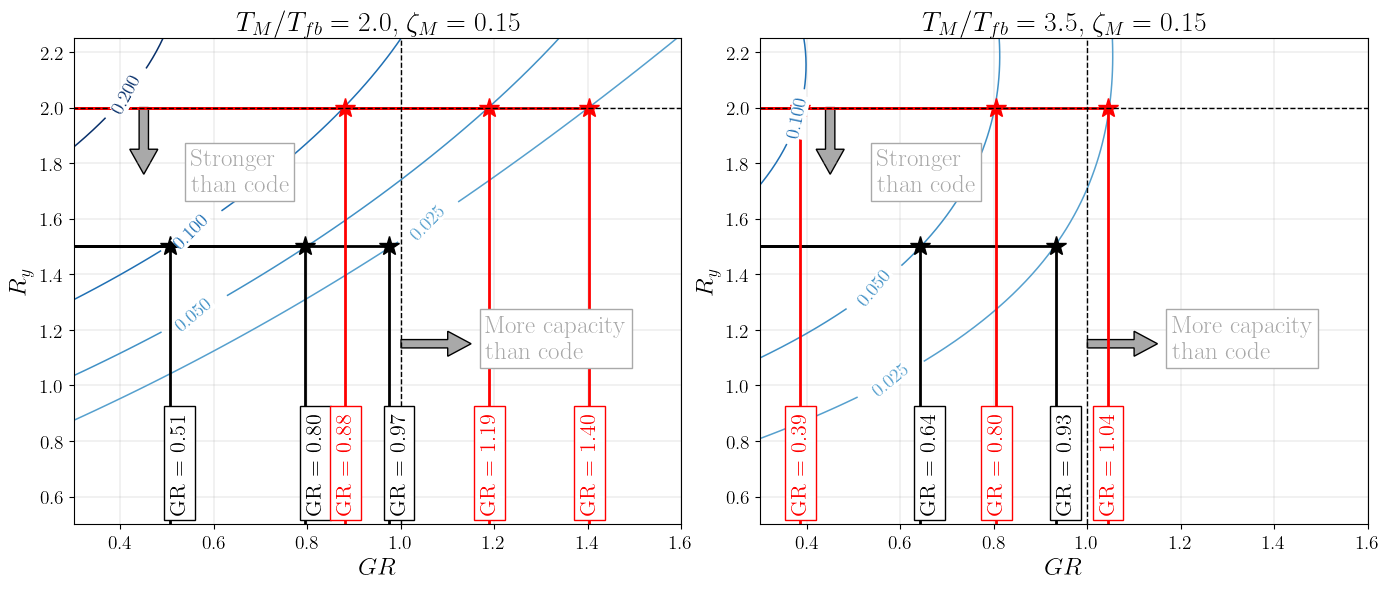

In [64]:
plt.close('all')

from inverse import make_2D_plotting_space

plt.rcParams["font.family"] = "serif"
plt.rcParams["mathtext.fontset"] = "dejavuserif"
title_font=20
axis_font = 18
subt_font = 16
label_size = 14
clabel_size = 14
mpl.rcParams['xtick.labelsize'] = label_size 
mpl.rcParams['ytick.labelsize'] = label_size 

lvls = np.array([0.025, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.75, 1.0])

res = 75
plt_density = 200
x_var = 'gap_ratio'
y_var = 'RI'
X_plot = make_2D_plotting_space(mdl_doe.X, res, x_var=x_var, y_var=y_var, 
                            all_vars=['gap_ratio', 'RI', 'T_ratio', 'zeta_e'],
                            x_bounds = [0.3, 2.0], y_bounds = [0.5, 2.25],
                            third_var_set = 2.0, fourth_var_set = 0.1)
xx = X_plot[x_var]
yy = X_plot[y_var]
x_pl = np.unique(xx)
y_pl = np.unique(yy)
xx_pl, yy_pl = np.meshgrid(x_pl, y_pl)

fmu_highlight = mdl_doe.gpr.predict(X_plot, return_std=False)

Z_highlight = fmu_highlight.reshape(xx_pl.shape)

fig = plt.figure(figsize=(14,6))



##########################################################################

X_plot = make_2D_plotting_space(mdl_doe.X, res, x_var=x_var, y_var=y_var, 
                            all_vars=['gap_ratio', 'RI', 'T_ratio', 'zeta_e'],
                            x_bounds = [0.3, 2.0], y_bounds = [0.5, 2.25],
                            third_var_set = 2.0, fourth_var_set = 0.15)
xx = X_plot[x_var]
yy = X_plot[y_var]
x_pl = np.unique(xx)
y_pl = np.unique(yy)
xx_pl, yy_pl = np.meshgrid(x_pl, y_pl)

fmu_highlight = mdl_doe.gpr.predict(X_plot, return_std=False)

Z_highlight = fmu_highlight.reshape(xx_pl.shape)

ax=fig.add_subplot(1, 2, 1)

# Plot the surface.
cmap = plt.cm.Blues
cs = ax.contour(xx_pl, yy_pl, Z_highlight, levels=lvls,  linewidths=1.1, cmap=cmap,
                vmin=-0.2, vmax=0.2)
clabels = ax.clabel(cs, fontsize=clabel_size)
[txt.set_bbox(dict(facecolor='white', edgecolor='none', pad=0)) for txt in clabels]

# draw lines for design targets

prob_list = [0.025, 0.05, 0.1]
from scipy.interpolate import RegularGridInterpolator
for j, prob_des in enumerate(prob_list):
    xq = np.linspace(0.3, 2.0, 200)
    
    Ry_target = 1.5
    
    interp = RegularGridInterpolator((y_pl, x_pl), Z_highlight)
    pts = np.zeros((200,2))
    pts[:,1] = xq
    pts[:,0] = Ry_target
    
    lq = interp(pts)
    
    the_points = np.vstack((pts[:,0], pts[:,1], lq))
    
    theGapIdx = np.argmin(abs(lq - prob_des))
    
    theGap = xq[theGapIdx]
    theGap = xq[theGapIdx]
    ax.vlines(x=theGap, ymin=0.49, ymax=Ry_target, color='black',
                linewidth=2.0)
    ax.hlines(y=Ry_target, xmin=0.3, xmax=theGap, color='black', linewidth=2.0)
    ax.text(theGap, 0.55, r'GR = '+f'{theGap:,.2f}', rotation=90,
              fontsize=subt_font, color='black', bbox=dict(facecolor='white', edgecolor='black'))
    ax.plot([theGap], [Ry_target], marker='*', markersize=15, color='black')
    
    
    # Ry = 2.0
    Ry_target = 2.0
    pts[:,0] = Ry_target
    lq = interp(pts)
    
    the_points = np.vstack((pts[:,0], pts[:,1], lq))
    
    theGapIdx = np.argmin(abs(lq - prob_des))
    
    theGap = xq[theGapIdx]
    ax.vlines(x=theGap, ymin=0.49, ymax=Ry_target, color='red',
                linewidth=2.0)
    ax.hlines(y=Ry_target, xmin=0.3, xmax=theGap, color='red', linewidth=2.0)
    ax.text(theGap-0.02, 0.55, r'GR = '+f'{theGap:,.2f}', rotation=90,
              fontsize=subt_font, color='red', bbox=dict(facecolor='white', edgecolor='red'))
    ax.plot([theGap], [Ry_target], marker='*', markersize=15, color='red')
   
# df_sc = mdl_doe._raw_data
# df_sc = df_sc[(df_sc['T_ratio'] < 2.5) &
#               (df_sc['T_ratio'] > 1.5)]
 
# plt.scatter(df_sc['gap_ratio'][:50], df_sc['RI'][:50], 
#             c=df_sc['collapse_prob'][:50], alpha=0.6,
#             edgecolors='k', s=20.0, cmap=plt.cm.Blues, vmax=5e-1)

ax.vlines(x=1.0, ymin=0, ymax=3.0, color='black', linestyles='--',
          linewidth=1.0)   
ax.hlines(y=2.0, xmin=0.0, xmax=3.0, color='black', linestyles='--',
          linewidth=1.0)   
ax.text(0.55, 1.7, 'Stronger\n than code',
          fontsize=axis_font, color='darkgray', bbox=dict(facecolor='white', edgecolor='darkgray'))
ax.arrow(0.45, 2.0, 0.0, -0.15, width=0.02, facecolor='darkgray', edgecolor='black')
ax.text(1.18, 1.1, 'More capacity \n than code',
          fontsize=axis_font, color='darkgray', bbox=dict(facecolor='white', edgecolor='darkgray'))
ax.arrow(1.0, 1.15, 0.1, 0.0, width=0.03, head_length=0.05, facecolor='darkgray', edgecolor='black')

ax.set_xlabel(r'$GR$', fontsize=axis_font)
ax.set_ylabel(r'$R_y$', fontsize=axis_font)
ax.set_title(r' $T_M/T_{fb} = 2.0$, $\zeta_M = 0.15$', fontsize=title_font)
ax.set_xlim([0.3, 1.6])
ax.set_ylim([0.5, 2.25])
ax.grid(linewidth=0.25)

########################################
ax=fig.add_subplot(1, 2, 2)

X_plot = make_2D_plotting_space(mdl_doe.X, res, x_var=x_var, y_var=y_var, 
                            all_vars=['gap_ratio', 'RI', 'T_ratio', 'zeta_e'],
                            x_bounds = [0.3, 2.0], y_bounds = [0.5, 2.25],
                            third_var_set = 3.5, fourth_var_set = 0.15)
xx = X_plot[x_var]
yy = X_plot[y_var]
x_pl = np.unique(xx)
y_pl = np.unique(yy)
xx_pl, yy_pl = np.meshgrid(x_pl, y_pl)

fmu_highlight = mdl_doe.gpr.predict(X_plot, return_std=False)

Z_highlight = fmu_highlight.reshape(xx_pl.shape)

# Plot the surface.
cmap = plt.cm.Blues
cs = ax.contour(xx_pl, yy_pl, Z_highlight, levels=lvls,  linewidths=1.1, cmap=cmap,
                vmin=-0.2, vmax=0.2)
clabels = ax.clabel(cs, fontsize=clabel_size)
[txt.set_bbox(dict(facecolor='white', edgecolor='none', pad=0)) for txt in clabels]

# draw lines for design targets

prob_list = [0.025, 0.05, 0.1]
from scipy.interpolate import RegularGridInterpolator
for j, prob_des in enumerate(prob_list):
    xq = np.linspace(0.3, 2.0, 200)
    
    Ry_target = 1.5
    
    interp = RegularGridInterpolator((y_pl, x_pl), Z_highlight)
    pts = np.zeros((200,2))
    pts[:,1] = xq
    pts[:,0] = Ry_target
    
    lq = interp(pts)
    
    the_points = np.vstack((pts[:,0], pts[:,1], lq))
    
    theGapIdx = np.argmin(abs(lq - prob_des))
    
    theGap = xq[theGapIdx]
    if theGap > 0.31:
    
        ax.vlines(x=theGap, ymin=0.49, ymax=Ry_target, color='black',
                    linewidth=2.0)
        ax.hlines(y=Ry_target, xmin=0.3, xmax=theGap, color='black', linewidth=2.0)
        ax.text(theGap, 0.55, r'GR = '+f'{theGap:,.2f}', rotation=90,
                fontsize=subt_font, color='black', bbox=dict(facecolor='white', edgecolor='black'))
        ax.plot([theGap], [Ry_target], marker='*', markersize=15, color='black')
    
    
    # Ry = 2.0
    Ry_target = 2.0
    pts[:,0] = Ry_target
    lq = interp(pts)
    
    the_points = np.vstack((pts[:,0], pts[:,1], lq))
    
    theGapIdx = np.argmin(abs(lq - prob_des))
    
    theGap = xq[theGapIdx]
    if theGap > 0.31:
    
        ax.vlines(x=theGap, ymin=0.49, ymax=Ry_target, color='red',
                    linewidth=2.0)
        ax.hlines(y=Ry_target, xmin=0.3, xmax=theGap, color='red', linewidth=2.0)
        ax.text(theGap-0.02, 0.55, r'GR = '+f'{theGap:,.2f}', rotation=90,
                fontsize=subt_font, color='red', bbox=dict(facecolor='white', edgecolor='red'))
        ax.plot([theGap], [Ry_target], marker='*', markersize=15, color='red')
 
# df_sc = mdl_doe._raw_data
# df_sc = df_sc[(df_sc['T_ratio'] < 3.0) &
#               (df_sc['T_ratio'] > 4.0)]
   
# plt.scatter(df_sc['gap_ratio'][:50], df_sc['RI'][:50], 
#             c=df_sc['collapse_prob'][:50], alpha=0.6,
#             edgecolors='k', s=20.0, cmap=plt.cm.Blues, vmax=5e-1)

ax.vlines(x=1.0, ymin=0, ymax=3.0, color='black', linestyles='--',
          linewidth=1.0)   
ax.hlines(y=2.0, xmin=0.0, xmax=3.0, color='black', linestyles='--',
          linewidth=1.0)   
ax.text(0.55, 1.7, 'Stronger\n than code',
          fontsize=axis_font, color='darkgray', bbox=dict(facecolor='white', edgecolor='darkgray'))
ax.arrow(0.45, 2.0, 0.0, -0.15, width=0.02, facecolor='darkgray', edgecolor='black')
ax.text(1.18, 1.1, 'More capacity \n than code',
          fontsize=axis_font, color='darkgray', bbox=dict(facecolor='white', edgecolor='darkgray'))
ax.arrow(1.0, 1.15, 0.1, 0.0, width=0.03, head_length=0.05, facecolor='darkgray', edgecolor='black')

ax.set_xlabel(r'$GR$', fontsize=axis_font)
ax.set_ylabel(r'$R_y$', fontsize=axis_font)
ax.set_title(r' $T_M/T_{fb} = 3.5$, $\zeta_M = 0.15$', fontsize=title_font)
ax.set_xlim([0.3, 1.6])
ax.set_ylim([0.5, 2.25])
ax.grid(linewidth=0.25)
##########################################################################

    
fig.tight_layout(w_pad=0.2)

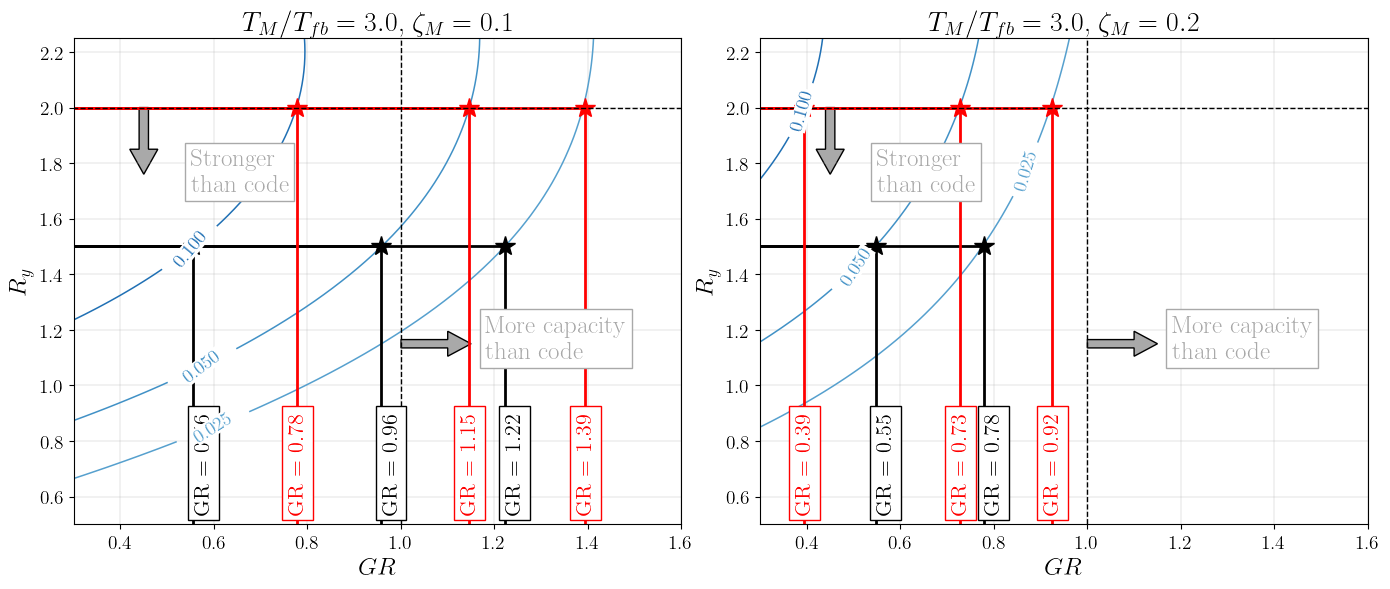

In [63]:
plt.close('all')

from inverse import make_2D_plotting_space

plt.rcParams["font.family"] = "serif"
plt.rcParams["mathtext.fontset"] = "dejavuserif"
title_font=20
axis_font = 18
subt_font = 16
label_size = 14
clabel_size = 14
mpl.rcParams['xtick.labelsize'] = label_size 
mpl.rcParams['ytick.labelsize'] = label_size 

lvls = np.array([0.025, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.75, 1.0])

res = 75
plt_density = 200
x_var = 'gap_ratio'
y_var = 'RI'
X_plot = make_2D_plotting_space(mdl_doe.X, res, x_var=x_var, y_var=y_var, 
                            all_vars=['gap_ratio', 'RI', 'T_ratio', 'zeta_e'],
                            x_bounds = [0.3, 2.0], y_bounds = [0.5, 2.25],
                            third_var_set = 2.0, fourth_var_set = 0.1)
xx = X_plot[x_var]
yy = X_plot[y_var]
x_pl = np.unique(xx)
y_pl = np.unique(yy)
xx_pl, yy_pl = np.meshgrid(x_pl, y_pl)

fmu_highlight = mdl_doe.gpr.predict(X_plot, return_std=False)

Z_highlight = fmu_highlight.reshape(xx_pl.shape)

fig = plt.figure(figsize=(14,6))



##########################################################################

X_plot = make_2D_plotting_space(mdl_doe.X, res, x_var=x_var, y_var=y_var, 
                            all_vars=['gap_ratio', 'RI', 'T_ratio', 'zeta_e'],
                            x_bounds = [0.3, 2.0], y_bounds = [0.5, 2.25],
                            third_var_set = 3.0, fourth_var_set = 0.1)
xx = X_plot[x_var]
yy = X_plot[y_var]
x_pl = np.unique(xx)
y_pl = np.unique(yy)
xx_pl, yy_pl = np.meshgrid(x_pl, y_pl)

fmu_highlight = mdl_doe.gpr.predict(X_plot, return_std=False)

Z_highlight = fmu_highlight.reshape(xx_pl.shape)

ax=fig.add_subplot(1, 2, 1)

# Plot the surface.
cmap = plt.cm.Blues
cs = ax.contour(xx_pl, yy_pl, Z_highlight, levels=lvls,  linewidths=1.1, cmap=cmap,
                vmin=-0.2, vmax=0.2)
clabels = ax.clabel(cs, fontsize=clabel_size)
[txt.set_bbox(dict(facecolor='white', edgecolor='none', pad=0)) for txt in clabels]

# draw lines for design targets

prob_list = [0.025, 0.05, 0.1]
from scipy.interpolate import RegularGridInterpolator
for j, prob_des in enumerate(prob_list):
    xq = np.linspace(0.3, 2.0, 200)
    
    Ry_target = 1.5
    
    interp = RegularGridInterpolator((y_pl, x_pl), Z_highlight)
    pts = np.zeros((200,2))
    pts[:,1] = xq
    pts[:,0] = Ry_target
    
    lq = interp(pts)
    
    the_points = np.vstack((pts[:,0], pts[:,1], lq))
    
    theGapIdx = np.argmin(abs(lq - prob_des))
    
    theGap = xq[theGapIdx]
    theGap = xq[theGapIdx]
    ax.vlines(x=theGap, ymin=0.49, ymax=Ry_target, color='black',
                linewidth=2.0)
    ax.hlines(y=Ry_target, xmin=0.3, xmax=theGap, color='black', linewidth=2.0)
    ax.text(theGap, 0.55, r'GR = '+f'{theGap:,.2f}', rotation=90,
              fontsize=subt_font, color='black', bbox=dict(facecolor='white', edgecolor='black'))
    ax.plot([theGap], [Ry_target], marker='*', markersize=15, color='black')
    
    
    # Ry = 2.0
    Ry_target = 2.0
    pts[:,0] = Ry_target
    lq = interp(pts)
    
    the_points = np.vstack((pts[:,0], pts[:,1], lq))
    
    theGapIdx = np.argmin(abs(lq - prob_des))
    
    theGap = xq[theGapIdx]
    ax.vlines(x=theGap, ymin=0.49, ymax=Ry_target, color='red',
                linewidth=2.0)
    ax.hlines(y=Ry_target, xmin=0.3, xmax=theGap, color='red', linewidth=2.0)
    ax.text(theGap-0.02, 0.55, r'GR = '+f'{theGap:,.2f}', rotation=90,
              fontsize=subt_font, color='red', bbox=dict(facecolor='white', edgecolor='red'))
    ax.plot([theGap], [Ry_target], marker='*', markersize=15, color='red')
   
# df_sc = mdl_doe._raw_data
# df_sc = df_sc[(df_sc['T_ratio'] < 2.5) &
#               (df_sc['T_ratio'] > 1.5)]
 
# plt.scatter(df_sc['gap_ratio'][:50], df_sc['RI'][:50], 
#             c=df_sc['collapse_prob'][:50], alpha=0.6,
#             edgecolors='k', s=20.0, cmap=plt.cm.Blues, vmax=5e-1)

ax.vlines(x=1.0, ymin=0, ymax=3.0, color='black', linestyles='--',
          linewidth=1.0)   
ax.hlines(y=2.0, xmin=0.0, xmax=3.0, color='black', linestyles='--',
          linewidth=1.0)   
ax.text(0.55, 1.7, 'Stronger\n than code',
          fontsize=axis_font, color='darkgray', bbox=dict(facecolor='white', edgecolor='darkgray'))
ax.arrow(0.45, 2.0, 0.0, -0.15, width=0.02, facecolor='darkgray', edgecolor='black')
ax.text(1.18, 1.1, 'More capacity \n than code',
          fontsize=axis_font, color='darkgray', bbox=dict(facecolor='white', edgecolor='darkgray'))
ax.arrow(1.0, 1.15, 0.1, 0.0, width=0.03, head_length=0.05, facecolor='darkgray', edgecolor='black')

ax.set_xlabel(r'$GR$', fontsize=axis_font)
ax.set_ylabel(r'$R_y$', fontsize=axis_font)
ax.set_title(r' $T_M/T_{fb} = 3.0$, $\zeta_M = 0.1$', fontsize=title_font)
ax.set_xlim([0.3, 1.6])
ax.set_ylim([0.5, 2.25])
ax.grid(linewidth=0.25)

########################################
ax=fig.add_subplot(1, 2, 2)

X_plot = make_2D_plotting_space(mdl_doe.X, res, x_var=x_var, y_var=y_var, 
                            all_vars=['gap_ratio', 'RI', 'T_ratio', 'zeta_e'],
                            x_bounds = [0.3, 2.0], y_bounds = [0.5, 2.25],
                            third_var_set = 3.0, fourth_var_set = 0.2)
xx = X_plot[x_var]
yy = X_plot[y_var]
x_pl = np.unique(xx)
y_pl = np.unique(yy)
xx_pl, yy_pl = np.meshgrid(x_pl, y_pl)

fmu_highlight = mdl_doe.gpr.predict(X_plot, return_std=False)

Z_highlight = fmu_highlight.reshape(xx_pl.shape)

# Plot the surface.
cmap = plt.cm.Blues
cs = ax.contour(xx_pl, yy_pl, Z_highlight, levels=lvls,  linewidths=1.1, cmap=cmap,
                vmin=-0.2, vmax=0.2)
clabels = ax.clabel(cs, fontsize=clabel_size)
[txt.set_bbox(dict(facecolor='white', edgecolor='none', pad=0)) for txt in clabels]

# draw lines for design targets

prob_list = [0.025, 0.05, 0.1]
from scipy.interpolate import RegularGridInterpolator
for j, prob_des in enumerate(prob_list):
    xq = np.linspace(0.3, 2.0, 200)
    
    Ry_target = 1.5
    
    interp = RegularGridInterpolator((y_pl, x_pl), Z_highlight)
    pts = np.zeros((200,2))
    pts[:,1] = xq
    pts[:,0] = Ry_target
    
    lq = interp(pts)
    
    the_points = np.vstack((pts[:,0], pts[:,1], lq))
    
    theGapIdx = np.argmin(abs(lq - prob_des))
    
    theGap = xq[theGapIdx]
    if theGap > 0.31:
    
        ax.vlines(x=theGap, ymin=0.49, ymax=Ry_target, color='black',
                    linewidth=2.0)
        ax.hlines(y=Ry_target, xmin=0.3, xmax=theGap, color='black', linewidth=2.0)
        ax.text(theGap, 0.55, r'GR = '+f'{theGap:,.2f}', rotation=90,
                fontsize=subt_font, color='black', bbox=dict(facecolor='white', edgecolor='black'))
        ax.plot([theGap], [Ry_target], marker='*', markersize=15, color='black')
    
    
    # Ry = 2.0
    Ry_target = 2.0
    pts[:,0] = Ry_target
    lq = interp(pts)
    
    the_points = np.vstack((pts[:,0], pts[:,1], lq))
    
    theGapIdx = np.argmin(abs(lq - prob_des))
    
    theGap = xq[theGapIdx]
    if theGap > 0.31:
    
        ax.vlines(x=theGap, ymin=0.49, ymax=Ry_target, color='red',
                    linewidth=2.0)
        ax.hlines(y=Ry_target, xmin=0.3, xmax=theGap, color='red', linewidth=2.0)
        ax.text(theGap-0.02, 0.55, r'GR = '+f'{theGap:,.2f}', rotation=90,
                fontsize=subt_font, color='red', bbox=dict(facecolor='white', edgecolor='red'))
        ax.plot([theGap], [Ry_target], marker='*', markersize=15, color='red')
 
# df_sc = mdl_doe._raw_data
# df_sc = df_sc[(df_sc['T_ratio'] < 3.0) &
#               (df_sc['T_ratio'] > 4.0)]
   
# plt.scatter(df_sc['gap_ratio'][:50], df_sc['RI'][:50], 
#             c=df_sc['collapse_prob'][:50], alpha=0.6,
#             edgecolors='k', s=20.0, cmap=plt.cm.Blues, vmax=5e-1)

ax.vlines(x=1.0, ymin=0, ymax=3.0, color='black', linestyles='--',
          linewidth=1.0)   
ax.hlines(y=2.0, xmin=0.0, xmax=3.0, color='black', linestyles='--',
          linewidth=1.0)   
ax.text(0.55, 1.7, 'Stronger\n than code',
          fontsize=axis_font, color='darkgray', bbox=dict(facecolor='white', edgecolor='darkgray'))
ax.arrow(0.45, 2.0, 0.0, -0.15, width=0.02, facecolor='darkgray', edgecolor='black')
ax.text(1.18, 1.1, 'More capacity \n than code',
          fontsize=axis_font, color='darkgray', bbox=dict(facecolor='white', edgecolor='darkgray'))
ax.arrow(1.0, 1.15, 0.1, 0.0, width=0.03, head_length=0.05, facecolor='darkgray', edgecolor='black')

ax.set_xlabel(r'$GR$', fontsize=axis_font)
ax.set_ylabel(r'$R_y$', fontsize=axis_font)
ax.set_title(r' $T_M/T_{fb} = 3.0$, $\zeta_M = 0.2$', fontsize=title_font)
ax.set_xlim([0.3, 1.6])
ax.set_ylim([0.5, 2.25])
ax.grid(linewidth=0.25)
##########################################################################
    
fig.tight_layout(w_pad=0.2)

### Validation fragility for collapse

In [56]:
def df_collapse(df, drift_mu_plus_std=0.1):
    
    from experiment import collapse_fragility
    df[['max_drift',
       'collapse_prob']] = df.apply(
           lambda row: collapse_fragility(
               row, mf_drift_mu_plus_std=drift_mu_plus_std), 
           axis='columns', result_type='expand')
                           
    from numpy import log
    df['log_collapse_prob'] = log(df['collapse_prob'])
    
    return df
    

#%% full validation (IDA data)

val_dir = '../../data/validation/'

val_10_file = 'tfp_mf_db_ida_10.pickle'
val_5_file = 'tfp_mf_db_ida_5.pickle'
val_2_file = 'tfp_mf_db_ida_2_5.pickle'
baseline_file = 'tfp_mf_db_ida_baseline.pickle'

main_obj_val = pd.read_pickle(val_dir+val_10_file)
df_val_10 = df_collapse(main_obj_val.ida_results)
df_val_10 = df_val_10.reset_index(drop=True)

main_obj_val = pd.read_pickle(val_dir+val_5_file)
df_val_5 = df_collapse(main_obj_val.ida_results)
df_val_5 = df_val_5.reset_index(drop=True)

main_obj_val = pd.read_pickle(val_dir+val_2_file)
df_val_2_5 = df_collapse(main_obj_val.ida_results)
df_val_2_5 = df_val_2_5.reset_index(drop=True)

main_obj_val = pd.read_pickle(val_dir+baseline_file)
df_base = df_collapse(main_obj_val.ida_results)
df_base = df_base.reset_index(drop=True)

ida_levels = [1.0, 1.5, 2.0]
val_10_collapse = np.zeros((3,))
val_5_collapse = np.zeros((3,))
val_2_collapse = np.zeros((3,))
baseline_collapse = np.zeros((3,))

for i, lvl in enumerate(ida_levels):
    val_10_ida = df_val_10[df_val_10['ida_level']==lvl]
    val_5_ida = df_val_5[df_val_5['ida_level']==lvl]
    val_2_ida = df_val_2_5[df_val_2_5['ida_level']==lvl]
    base_ida = df_base[df_base['ida_level']==lvl]
    
    val_10_collapse[i] = val_10_ida['collapse_prob'].mean()
    val_5_collapse[i] = val_5_ida['collapse_prob'].mean()
    val_2_collapse[i] = val_2_ida['collapse_prob'].mean()
    
    baseline_collapse[i] = base_ida['collapse_prob'].mean()

C:\Users\hgp\AppData\Local\Temp\ipykernel_13824\1388381812.py:7: RuntimeWarning: divide by zero encountered in log
  log_likelihood = np.log(likelihood)


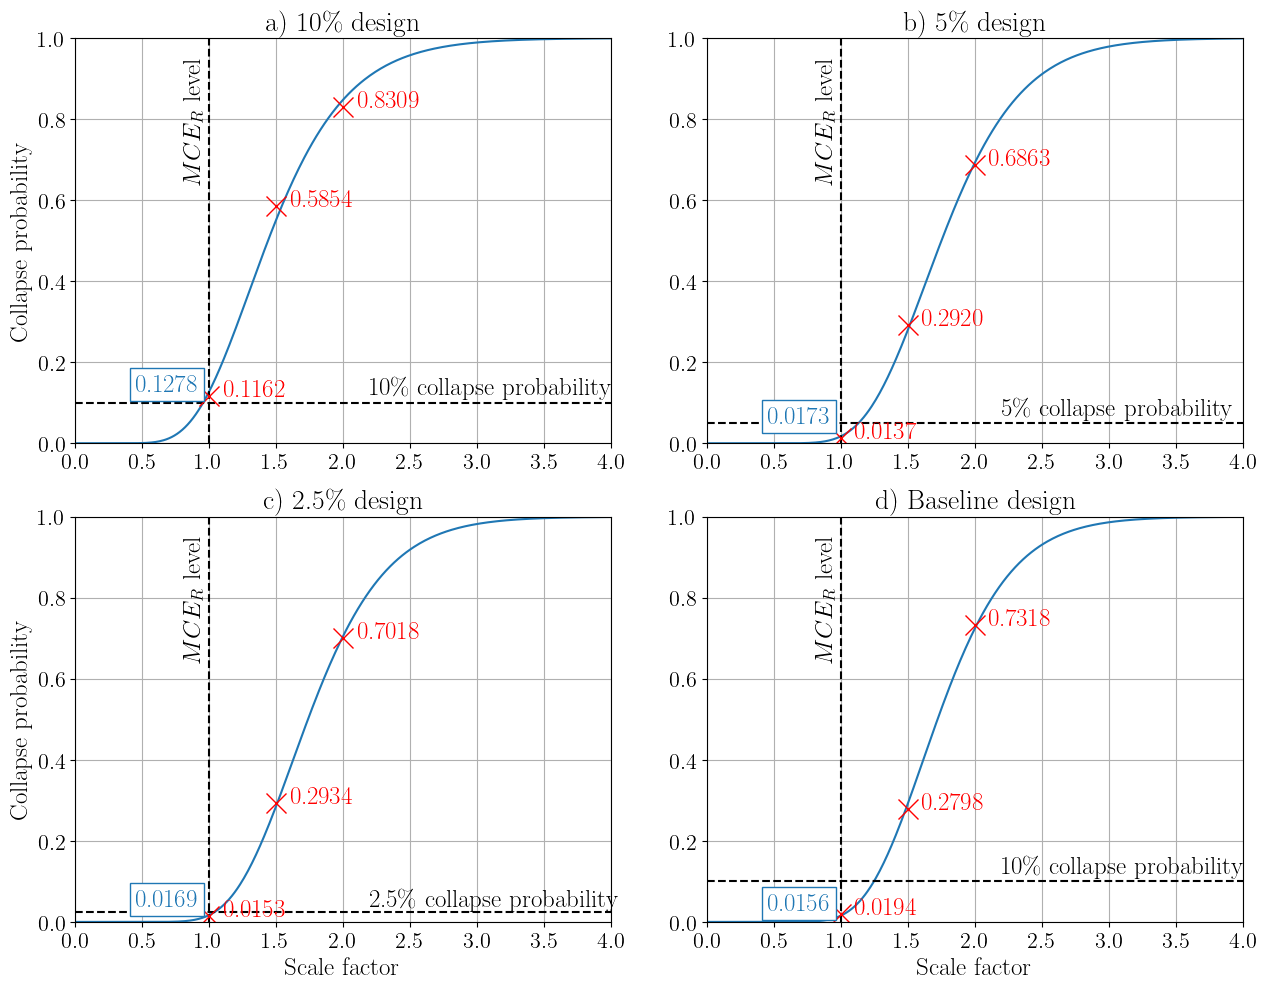

In [59]:
def neg_log_likelihood_sum(params, im_l, no_a, no_c):
    from scipy import stats
    import numpy as np
    sigma, beta = params
    theoretical_fragility_function = stats.norm(np.log(sigma), beta).cdf(im_l)
    likelihood = stats.binom.pmf(no_c, no_a, theoretical_fragility_function)
    log_likelihood = np.log(likelihood)
    log_likelihood_sum = np.sum(log_likelihood)

    return -log_likelihood_sum

def mle_fit_collapse(ida_levels, pr_collapse):
    from functools import partial
    import numpy as np
    from scipy import optimize
    
    im_log = np.log(ida_levels)
    number_of_analyses = np.array([1000, 1000, 1000 ])
    number_of_collapses = np.round(1000*pr_collapse)
    
    neg_log_likelihood_sum_partial = partial(
        neg_log_likelihood_sum, im_l=im_log, no_a=number_of_analyses, no_c=number_of_collapses)
    
    
    res = optimize.minimize(neg_log_likelihood_sum_partial, (1, 1), method="Nelder-Mead")
    return res.x[0], res.x[1]


from scipy.stats import norm
f = lambda x,theta,beta: norm(np.log(theta), beta).cdf(np.log(x))

color = plt.cm.tab10(np.linspace(0, 1, 10))

plt.rcParams["font.family"] = "serif"
plt.rcParams["mathtext.fontset"] = "dejavuserif"
axis_font = 18
subt_font = 18
label_size = 16
title_font=20
mpl.rcParams['xtick.labelsize'] = label_size 
mpl.rcParams['ytick.labelsize'] = label_size 
plt.close('all')

fig = plt.figure(figsize=(13, 10))

b_TOT = np.linalg.norm([0.2, 0.2, 0.2, 0.4])

theta_10, beta_10 = mle_fit_collapse(ida_levels,val_10_collapse)

xx_pr = np.arange(0.01, 4.0, 0.01)
p = f(xx_pr, theta_10, beta_10)
p2 = f(xx_pr, theta_10, b_TOT)

MCE_level = float(p[xx_pr==1.0])
MCE_level_unc = float(p2[xx_pr==1.0])
ax1=fig.add_subplot(2, 2, 1)
ax1.plot(xx_pr, p)
# ax1.plot(xx_pr, p2)
ax1.axhline(0.1, linestyle='--', color='black')
ax1.axvline(1.0, linestyle='--', color='black')
ax1.text(2.2, 0.12, r'10\% collapse probability',
          fontsize=subt_font, color='black')
ax1.text(0.45, 0.13, f'{MCE_level:,.4f}',
          fontsize=subt_font, color=color[0], bbox=dict(facecolor='white', edgecolor=color[0]))
# ax1.text(0.2, 0.12, f'{MCE_level_unc:,.4f}',
#           fontsize=subt_font, color='orange')
ax1.text(0.8, 0.65, r'$MCE_R$ level', rotation=90,
          fontsize=subt_font, color='black')

ax1.set_ylabel('Collapse probability', fontsize=axis_font)
# ax1.set_xlabel(r'Scale factor', fontsize=axis_font)
ax1.set_title('a) 10\% design', fontsize=title_font)
for i, lvl in enumerate(ida_levels):
    ax1.plot([lvl], [val_10_collapse[i]], 
              marker='x', markersize=15, color="red")
    val = val_10_collapse[i]
    ax1.text(lvl+0.1, val, f'{val:,.4f}',
              fontsize=subt_font, color='red')
ax1.grid()
ax1.set_xlim([0, 4.0])
ax1.set_ylim([0, 1.0])

####
theta_5, beta_5 = mle_fit_collapse(ida_levels,val_5_collapse)
xx_pr = np.arange(0.01, 4.0, 0.01)
p = f(xx_pr, theta_5, beta_5)
p2 = f(xx_pr, theta_5, b_TOT)

MCE_level = float(p[xx_pr==1.0])
MCE_level_unc = float(p2[xx_pr==1.0])
ax2=fig.add_subplot(2, 2, 2)
ax2.plot(xx_pr, p)
# ax2.plot(xx_pr, p2)
ax2.axhline(0.05, linestyle='--', color='black')
ax2.axvline(1.0, linestyle='--', color='black')
ax2.text(0.8, 0.65, r'$MCE_R$ level', rotation=90,
          fontsize=subt_font, color='black')
ax2.text(2.2, 0.07, r'5\% collapse probability',
          fontsize=subt_font, color='black')
ax2.text(0.45, 0.05, f'{MCE_level:,.4f}',
          fontsize=subt_font, color=color[0], bbox=dict(facecolor='white', edgecolor=color[0]))
# ax2.text(0.3, 0.17, f'{MCE_level_unc:,.4f}',
#           fontsize=subt_font, color='orange')

# ax2.set_ylabel('Collapse probability', fontsize=axis_font)
# ax2.set_xlabel(r'Scale factor', fontsize=axis_font)
ax2.set_title('b) 5\% design', fontsize=title_font)
for i, lvl in enumerate(ida_levels):
    ax2.plot([lvl], [val_5_collapse[i]], 
              marker='x', markersize=15, color="red")
    val = val_5_collapse[i]
    ax2.text(lvl+0.1, val, f'{val:,.4f}',
              fontsize=subt_font, color='red')
ax2.grid()
ax2.set_xlim([0, 4.0])
ax2.set_ylim([0, 1.0])

####
theta_2, beta_2 = mle_fit_collapse(ida_levels,val_2_collapse)
xx_pr = np.arange(0.01, 4.0, 0.01)
p = f(xx_pr, theta_2, beta_2)
p2 = f(xx_pr, theta_2, b_TOT)

MCE_level = float(p[xx_pr==1.0])
MCE_level_unc = float(p2[xx_pr==1.0])
ax3=fig.add_subplot(2, 2, 3)
ax3.plot(xx_pr, p)
# ax3.plot(xx_pr, p2)
ax3.axhline(0.025, linestyle='--', color='black')
ax3.axvline(1.0, linestyle='--', color='black')
ax3.text(0.8, 0.65, r'$MCE_R$ level', rotation=90,
          fontsize=subt_font, color='black')
ax3.text(2.2, 0.04, r'2.5\% collapse probability',
          fontsize=subt_font, color='black')
ax3.text(0.45, 0.04, f'{MCE_level:,.4f}',
          fontsize=subt_font, color=color[0], bbox=dict(facecolor='white', edgecolor=color[0]))
# ax3.text(0.25, 0.04, f'{MCE_level_unc:,.4f}',
#           fontsize=subt_font, color='orange')

ax3.set_ylabel('Collapse probability', fontsize=axis_font)
ax3.set_xlabel(r'Scale factor', fontsize=axis_font)
ax3.set_title('c) 2.5\% design', fontsize=title_font)
for i, lvl in enumerate(ida_levels):
    ax3.plot([lvl], [val_2_collapse[i]], 
              marker='x', markersize=15, color="red")
    val = val_2_collapse[i]
    ax3.text(lvl+0.1, val, f'{val:,.4f}',
              fontsize=subt_font, color='red')
ax3.grid()
ax3.set_xlim([0, 4.0])
ax3.set_ylim([0, 1.0])

####
theta_base, beta_base = mle_fit_collapse(ida_levels, baseline_collapse)
xx_pr = np.arange(0.01, 4.0, 0.01)
p = f(xx_pr, theta_base, beta_base)
p2 = f(xx_pr, theta_base, b_TOT)

MCE_level = float(p[xx_pr==1.0])
MCE_level_unc = float(p2[xx_pr==1.0])
ax4=fig.add_subplot(2, 2, 4)
ax4.plot(xx_pr, p, label='Best lognormal fit')
# ax4.plot(xx_pr, p2, label='Adjusted for uncertainty')
ax4.axhline(0.1, linestyle='--', color='black')
# ax4.axhline(baseline_risk, linestyle='--', color='steelblue')
# ax4.text(2.2, 0.01, r'GP predicted risk',
#           fontsize=subt_font, color='steelblue')
ax4.axvline(1.0, linestyle='--', color='black')
ax4.text(0.8, 0.65, r'$MCE_R$ level', rotation=90,
          fontsize=subt_font, color='black')
ax4.text(2.2, 0.12, r'10\% collapse probability',
          fontsize=subt_font, color='black')
ax4.text(0.45, 0.03, f'{MCE_level:,.4f}',
          fontsize=subt_font, color=color[0], bbox=dict(facecolor='white', edgecolor=color[0]))
# ax4.text(0.2, 0.2, f'{MCE_level_unc:,.4f}',
#           fontsize=subt_font, color='orange')

# ax4.set_ylabel('Collapse probability', fontsize=axis_font)
ax4.set_xlabel(r'Scale factor', fontsize=axis_font)
ax4.set_title('d) Baseline design', fontsize=title_font)
for i, lvl in enumerate(ida_levels):
    ax4.plot([lvl], [baseline_collapse[i]], 
              marker='x', markersize=15, color="red")
    val = baseline_collapse[i]
    ax4.text(lvl+0.1, val, f'{val:,.4f}',
              fontsize=subt_font, color='red')
ax4.grid()
ax4.set_xlim([0, 4.0])
ax4.set_ylim([0, 1.0])
# ax4.legend(fontsize=subt_font-2, loc='center right')

fig.tight_layout()
# plt.savefig('./figures/fragility_curve.eps', dpi=1200, format='eps')
plt.show()

# Functionality study

### Load, process, subset

In [4]:
import inverse as inv

# <change these to your paths> 
path_to_loss_file = '../../data/loss/structural_db_complete_distributions.pickle'
path_to_max_file = '../../data/loss/structural_db_complete_max_loss.pickle'

# also change this to point to the directory with the brace database
# (should be ../data/, I think)
path_to_braceShapes = '../../resource/'


main_obj = pd.read_pickle(path_to_loss_file)
df_loss = main_obj.loss_data
max_obj = pd.read_pickle(path_to_max_file)
df = inv.preprocess_data(main_obj, max_obj, db_string=path_to_braceShapes)

#%% subsets 
df_tfp = df[df['isolator_system'] == 'TFP']
df_lrb = df[df['isolator_system'] == 'LRB']

df_cbf = df[df['superstructure_system'] == 'CBF'].reset_index()
df_cbf['dummy_index'] = df_cbf['replacement_freq'] + df_cbf['index']*1e-9
df_mf = df[df['superstructure_system'] == 'MF'].reset_index()
df_mf['dummy_index'] = df_mf['replacement_freq'] + df_mf['index']*1e-9

df_mf_o = df_mf[df_mf['impacted'] == 0]
df_cbf_o = df_cbf[df_cbf['impacted'] == 0]

df_mf_tfp = df_tfp[df_tfp['superstructure_system'] == 'MF']
df_mf_lrb = df_lrb[df_lrb['superstructure_system'] == 'MF']

df_cbf_tfp = df_tfp[df_tfp['superstructure_system'] == 'CBF']
df_cbf_lrb = df_lrb[df_lrb['superstructure_system'] == 'CBF']


df_mf_tfp_i = df_mf_tfp[df_mf_tfp['impacted'] == 1]
df_mf_tfp_o = df_mf_tfp[df_mf_tfp['impacted'] == 0]
df_mf_lrb_i = df_mf_lrb[df_mf_lrb['impacted'] == 1]
df_mf_lrb_o = df_mf_lrb[df_mf_lrb['impacted'] == 0]

df_cbf_tfp_i = df_cbf_tfp[df_cbf_tfp['impacted'] == 1]
df_cbf_tfp_o = df_cbf_tfp[df_cbf_tfp['impacted'] == 0]
df_cbf_lrb_i = df_cbf_lrb[df_cbf_lrb['impacted'] == 1]
df_cbf_lrb_o = df_cbf_lrb[df_cbf_lrb['impacted'] == 0]